In [1]:
import numpy as np
import cv2
#from keras.datasets import mnist
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Dataset

In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# x_train = x_train.astype(float) / 255.
# x_test = x_test.astype(float) / 255.

# # extraemos los últimos 10K datos para validación
# x_train, x_val = x_train[:-10000], x_train[-10000:]
# y_train, y_val = y_train[:-10000], y_train[-10000:]

# x_train = x_train.reshape([x_train.shape[0], -1])
# x_val = x_val.reshape([x_val.shape[0], -1])
# x_test = x_test.reshape([x_test.shape[0], -1])

In [4]:
# ####ONE HOT ENCODE####
# new_y_train = np.zeros((y_train.shape[0], 10))
# new_y_train[range(len(y_train)), y_train] = 1

# new_y_val = np.zeros((y_val.shape[0], 10))
# new_y_val[range(len(y_val)), y_val] = 1

# new_y_test = np.zeros((y_test.shape[0], 10))
# new_y_test[range(len(y_test)), y_test] = 1

In [5]:
# np.save('x_train', x_train)
# np.save('y_train', new_y_train)
# np.save('x_val', x_val)
# np.save('y_val', new_y_val)
# np.save('x_test', x_test)
# np.save('y_test', new_y_test)

In [6]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)
(10000, 784)
(10000, 10)


# Softmax and Cross Entropy

In [8]:
def stable_softmax(Z):
    exps = np.exp(Z - np.max(Z))
    return exps / exps.sum(axis=-1,keepdims=True) ##Sumatoria se realiza para cada fila

In [9]:
def grad_softmax_crossentropy(Y_hat, Y):
    """
    Y: Etiquetas de tamaño (m, c) //m: nro ejemplos, c: nro clases
    Y_hat: Predicciones (stable softmax) de tamaño (m, c) //m: nro ejemplos, c: nro clases
    """
    return (Y_hat - Y) / Y.shape[0] ## . /len(Y_hat) es el término (1/m)

In [10]:
def cross_entropy_with_logits(Z: np.ndarray, Y: np.ndarray):
    """
    Z: La predicción de la última capa sin activar (m, c)
    Y: El vector de etiquetas sin one hot encoding (m,). Si es de tamaño (m, c) se extraerá solo
    """
    if len(Y.shape) > 1:
        Y = Y.argmax(axis=-1)
    
    Z_j = Z[range(len(Z)), Y] ## LA PREDICCIÓN SIN ACTIVAR EN LA COLUMNA DEL Y CORRESPONDIENTE
    loss = - Z_j + np.log(np.sum(np.exp(Z),axis=-1)) ## LOG SOFTMAX CON LA SUMATORI PARA CADA FILA
    
    return loss

# Softmax Regression

In [11]:
def predict(theta, x, bias):
    return stable_softmax(x @ theta + bias)

In [12]:
####INITIALIZE THETAS####
input_size = 784
n_classes = 10
lr = 0.01

θ = np.random.randn(input_size, n_classes) * np.sqrt(2.0/input_size)
b = np.zeros(n_classes)

train_losses = []
val_losses = []
iters = 500
for it in tqdm(range(iters)):
#for it in range(iters):
    Z = x_train @ θ + b
    
    loss = cross_entropy_with_logits(Z, y_train)
    train_losses.append(loss.mean())
    val_losses.append(cross_entropy_with_logits(x_val@θ+b, y_val).mean())
    
    y_hat = stable_softmax(Z)
    
    dZ = grad_softmax_crossentropy(y_hat, y_train)
    dθ = x_train.T @ dZ
    db = dZ.sum(axis=0)
    
    θ = θ - lr*dθ
    b = b - lr*db

100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


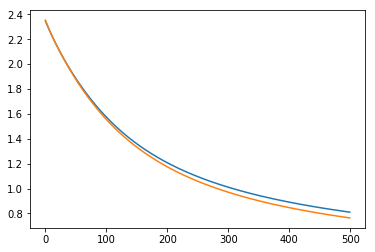

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [14]:
accuracy_score(np.argmax(predict(θ, x_test, b), axis=1), np.argmax(y_test, axis=1))

0.843

In [15]:
confusion_matrix(np.argmax(predict(θ, x_test, b), axis=1), np.argmax(y_test, axis=1))

array([[ 932,    0,   14,    5,    4,   31,   23,    7,   16,   20],
       [   0, 1083,   27,    5,   12,   27,    6,   42,   29,   17],
       [   1,    9,  841,   21,    7,    6,   16,   29,   15,    8],
       [   4,    5,   32,  872,    0,  118,    2,    1,   49,   16],
       [   1,    0,   23,    1,  840,   30,   27,   10,   10,   70],
       [   5,    4,    1,   26,    0,  562,   16,    0,   32,    7],
       [  22,    4,   22,    7,   23,   22,  860,    3,   25,    3],
       [   1,    0,   20,   24,    4,   16,    0,  869,   16,   35],
       [  13,   30,   44,   32,    9,   60,    7,   15,  754,   16],
       [   1,    0,    8,   17,   83,   20,    1,   52,   28,  817]])

# Red Neuronal

## Capas

In [16]:
class Layer:
    """
    Bloque base para definición de una capa
    """
    def __init__(self):
        """Inicialización de parámetros."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Recibe [batch, input_units], Y devuelve [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Aplicamos Backpropagation
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Se recibe d loss / d layer como entrada, así que sólo se debe multiplicar por d layer / d x.
        
        Si la capa tiene parámetros, se deben actualizar sus valores d loss / d layer
        """
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input)

In [17]:
class ReLU(Layer):
    def __init__(self):
        """No tiene parámetros entrenables"""
        pass
    
    def forward(self, input):
        """Aplica ReLU a [batch, input_units]"""
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        """Computa gradiente de loss respecto a ReLU"""
        relu_grad = input > 0
        return grad_output*relu_grad    #dL/dZ[l]    

In [18]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01, initializer='standard'):
        """
        Una capa densa que realiza un mapeo entre espacios:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        np.random.normal()
        
        ###PODEMOS ELEGIR LA FORMA DE INICIALIZACIÓN, LA ESTÁNDAR Y LA XAVIER###
        scaler = 0.01 if initializer == 'standard' else np.sqrt(2.0/input_units)
        
        self.weights = np.random.randn(input_units, output_units)*scaler
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input @ self.weights + self.biases #<your code here>
    
    def backward(self,input,grad_output):
        # Calculamos dL/dA[l-1]
        grad_input = grad_output @ self.weights.T #dL/dAl-1 = <dL/dZ[l], w[l]'> -> dL/dX
        
        # Calculamos para los pesos y los bias
        grad_weights = input.T @ grad_output #dL/dW[l] = <A[l]-1', dL/dZ[l]> -> dL/dθ
        grad_biases = np.sum(grad_output, axis=0) #dL/db[l] = sum_rows(b[l])
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Actualizamos parámetros
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input ## Retornamos grad para la anterior capa

## Entrenamiento

In [19]:
def forward(network, X):
    """
    Damos una pasada por toda la red propagando la información hacia delante.
    """
    activations = []
    input = X

    for layer in network:
        input = layer.forward(input)
        activations.append(input)    
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Calculamos un vector de predicciones
    """
    logits = forward(network,X)[-1]
    preds = stable_softmax(logits)
    #return logits.argmax(axis=-1) #Max element of each row
    return preds.argmax(axis=-1)

def train(network,X,y):
    """
    Realizar un paso de entrenamiento, un forward pass y un backward pass, junto con una actualización de pesos.
    """
    
    # Obtener activaciones
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] es una entrada para network[i]
    logits = layer_activations[-1] #extraemos la última capa sin activar
    
    # Calculamos el Loss y el gradiente inicial para retropopagar
    loss = cross_entropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy(stable_softmax(logits),y)
    
    # Retropopagamos
    for layer, input in zip(reversed(network), reversed(layer_inputs[:-1])):
        loss_grad = layer.backward(input, loss_grad)
        
    return np.mean(loss)

In [20]:
network = []
network.append(Dense(x_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [21]:
train(network, x_train[:100, :], y_train[:100])

2.3025220265031954

In [22]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Entrenando la Red

In [23]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.97418
Val accuracy: 0.9664


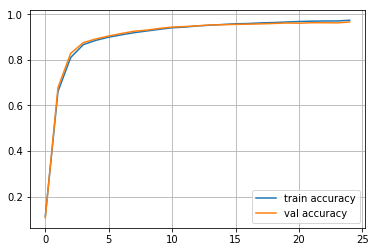

In [24]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(x_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    args_y_train = np.argmax(y_train, axis=-1)
    args_y_val = np.argmax(y_val, axis=-1)
    train_log.append(np.mean(predict(network,x_train)==args_y_train))
    val_log.append(np.mean(predict(network,x_val)==args_y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

In [25]:
accuracy_score(predict(network, x_test), np.argmax(y_test, axis=-1))

0.965

In [26]:
confusion_matrix(predict(network, x_test), np.argmax(y_test, axis=-1))

array([[ 962,    0,    5,    0,    0,    3,    5,    1,    2,    5],
       [   0, 1119,    3,    1,    0,    1,    3,    8,    6,    9],
       [   1,    3, 1003,    5,    5,    0,    3,   13,    2,    0],
       [   1,    2,    8,  981,    0,   16,    0,    5,    7,    8],
       [   1,    0,    4,    1,  961,    4,    9,    1,    6,   24],
       [   3,    2,    0,    6,    0,  842,    7,    1,   10,    5],
       [   5,    1,    1,    0,    2,    9,  926,    0,    6,    0],
       [   1,    2,    6,    8,    4,    0,    0,  990,    9,   12],
       [   3,    6,    2,    7,    1,   11,    5,    0,  925,    5],
       [   3,    0,    0,    1,    9,    6,    0,    9,    1,  941]])

# More Layers

In [27]:
network = []
network.append(Dense(x_train.shape[1], 100, initializer='xavier'))
network.append(ReLU())
network.append(Dense(100, 200, initializer='xavier'))
network.append(ReLU())
network.append(Dense(200, 200, initializer='xavier'))
network.append(ReLU())
network.append(Dense(200, 100, initializer='xavier'))
network.append(ReLU())
network.append(Dense(100, 10, initializer='xavier'))

Epoch 6
Train accuracy: 0.97972
Val accuracy: 0.9693


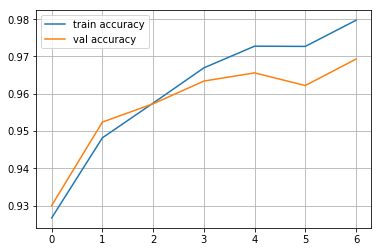

In [28]:
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(7):

    for x_batch,y_batch in iterate_minibatches(x_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    args_y_train = np.argmax(y_train, axis=-1)
    args_y_val = np.argmax(y_val, axis=-1)
    train_log.append(np.mean(predict(network,x_train)==args_y_train))
    val_log.append(np.mean(predict(network,x_val)==args_y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [29]:
accuracy_score(predict(network, x_test), np.argmax(y_test, axis=-1))

0.9682

In [30]:
confusion_matrix(predict(network, x_test), np.argmax(y_test, axis=-1))

array([[ 966,    0,    5,    0,    1,    6,    5,    1,    5,    7],
       [   0, 1124,    2,    2,    0,    1,    3,    8,    0,    5],
       [   2,    4, 1009,    9,    3,    0,    3,   15,    4,    4],
       [   1,    1,    3,  980,    0,   18,    1,    5,   15,   10],
       [   0,    1,    2,    0,  959,    3,    6,    0,    3,   18],
       [   3,    1,    0,    3,    0,  843,    3,    0,    5,    3],
       [   4,    2,    3,    0,    9,   11,  933,    0,    5,    0],
       [   3,    1,    4,    7,    3,    1,    0,  993,    8,   10],
       [   1,    1,    3,    8,    2,    5,    4,    1,  928,    5],
       [   0,    0,    1,    1,    5,    4,    0,    5,    1,  947]])

# Usando librerías

## Keras

In [31]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

Using TensorFlow backend.


In [32]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [33]:
optimizer = SGD(lr=0.1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x_train, y_train, batch_size=32, epochs=7, validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/7
50000/50000 [==============================] - 5s 97us/step - loss: 0.3300 - acc: 0.8976 - val_loss: 0.2145 - val_acc: 0.9355
Epoch 2/7
50000/50000 [==============================] - 5s 91us/step - loss: 0.1347 - acc: 0.9574 - val_loss: 0.1093 - val_acc: 0.9687
Epoch 3/7
50000/50000 [==============================] - 5s 91us/step - loss: 0.0939 - acc: 0.9704 - val_loss: 0.1453 - val_acc: 0.9554
Epoch 4/7
50000/50000 [==============================] - 5s 92us/step - loss: 0.0718 - acc: 0.9776 - val_loss: 0.1216 - val_acc: 0.9638
Epoch 5/7
50000/50000 [==============================] - 5s 96us/step - loss: 0.0565 - acc: 0.9818 - val_loss: 0.0975 - val_acc: 0.9729
Epoch 6/7
50000/50000 [==============================] - 5s 94us/step - loss: 0.0464 - acc: 0.9847 - val_loss: 0.1250 - val_acc: 0.9637
Epoch 7/7
50000/50000 [==============================] - 5s 95us/step - loss: 0.0394 - acc: 0.9872 - val_loss: 0.1155 - val_acc: 0.970

In [35]:
preds = model.predict(x_test)

In [36]:
accuracy_score(np.argmax(preds, axis=-1), np.argmax(y_test, axis=-1))

0.9682

In [37]:
confusion_matrix(np.argmax(preds, axis=-1), np.argmax(y_test, axis=-1))

array([[ 969,    0,    3,    0,    0,    3,    4,    1,    8,    5],
       [   1, 1124,    0,    0,    1,    0,    4,    4,    1,    2],
       [   3,    3, 1013,    4,    2,    0,    1,   10,   18,    1],
       [   1,    2,    4,  980,    0,    6,    2,    2,   38,    5],
       [   0,    0,    1,    0,  948,    0,    3,    2,    2,    7],
       [   1,    1,    2,   17,    2,  871,   10,    0,   27,    6],
       [   2,    2,    2,    0,    4,    5,  933,    0,    5,    1],
       [   2,    1,    6,    5,    2,    1,    0,  999,    3,    5],
       [   1,    2,    1,    4,    2,    3,    1,    1,  869,    1],
       [   0,    0,    0,    0,   21,    3,    0,    9,    3,  976]])

## Pytorch

In [38]:
import torch.nn as nn
import torch

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(x_train.shape[1], 100)
        self.g1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 200)
        self.g2 = nn.ReLU()
        self.fc3 = nn.Linear(200, 200)
        self.g3 = nn.ReLU()
        self.fc4 = nn.Linear(200, 100)
        self.g4 = nn.ReLU()
        self.fc5 = nn.Linear(100, 10)
        #self.g5 = nn.Softmax()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.g1(out)
        out = self.fc2(out)
        out = self.g2(out)
        out = self.fc3(out)
        out = self.g3(out)
        out = self.fc4(out)
        out = self.g4(out)
        out = self.fc5(out)
        #out = sefl.g5(out)
        
        return out

In [40]:
net = Net()

In [41]:
criterio = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(net.parameters(), lr=0.01)

In [42]:
for epoch in range(7):
    for x_batch,y_batch in iterate_minibatches(x_train,np.argmax(y_train,axis=-1),batchsize=32,shuffle=True):
        optimizer.zero_grad()
        y_hat = net(torch.from_numpy(x_batch).float())
        loss = criterio(y_hat, torch.from_numpy(y_batch).long())
        loss.backward()
        optimizer.step()
        
    print(loss.data[0])

100%|██████████| 1562/1562 [00:02<00:00, 527.93it/s]
/home/rafael/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':
  3%|▎         | 47/1562 [00:00<00:03, 466.83it/s]

tensor(2.0260)


  3%|▎         | 47/1562 [00:00<00:03, 465.46it/s]

tensor(0.3760)


  3%|▎         | 42/1562 [00:00<00:03, 411.71it/s]

tensor(0.4702)


  3%|▎         | 52/1562 [00:00<00:02, 513.23it/s]

tensor(0.4353)


  1%|▏         | 22/1562 [00:00<00:07, 217.70it/s]

tensor(0.0960)


  3%|▎         | 47/1562 [00:00<00:03, 463.04it/s]

tensor(0.2297)


100%|██████████| 1562/1562 [00:03<00:00, 480.22it/s]

tensor(0.0393)


In [43]:
y_hat = net(torch.from_numpy(x_test).float())
preds = y_hat.detach().numpy()
print(y_hat.shape)

torch.Size([10000, 10])


In [44]:
accuracy_score(np.argmax(preds, axis=-1), np.argmax(y_test, axis=-1))

0.9518

In [45]:
confusion_matrix(np.argmax(preds, axis=-1), np.argmax(y_test, axis=-1))

array([[ 961,    0,    8,    1,    1,    4,    6,    1,    2,    6],
       [   0, 1114,    3,    0,    2,    0,    3,   11,    3,    6],
       [   2,    2,  970,   24,    6,    0,    3,    8,    3,    1],
       [   0,    3,   10,  947,    0,   14,    0,    7,    8,    3],
       [   0,    0,    8,    0,  935,    2,    6,    3,    9,   19],
       [   6,    3,    0,    8,    1,  835,   18,    1,   14,    8],
       [   6,    1,   10,    0,    6,   12,  919,    0,    9,    0],
       [   2,    2,    9,   16,    3,    0,    0,  981,    3,   10],
       [   3,   10,   13,   12,    3,   18,    3,    0,  911,   11],
       [   0,    0,    1,    2,   25,    7,    0,   16,   12,  945]])